In [1]:
import sys
import os
TF_RCNN_PATH = "T:/lab6/tf-faster-rcnn-windows"

In [2]:
sys.path.append(os.path.join(TF_RCNN_PATH, ""))
sys.path.append(os.path.join(TF_RCNN_PATH, "lib"))
sys.path.append(os.path.join(TF_RCNN_PATH, "tools"))

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
from model.config import cfg
from model.test import im_detect
from model.nms_wrapper import nms

from utils.timer import Timer
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, cv2, io, json
import argparse
from matplotlib import pyplot as plt

from nets.mobilenet_v1 import mobilenetv1
from nets.resnet_v1 import resnetv1

In [4]:
# MODEL_PATH = os.path.join(TF_RCNN_PATH, "output/mobile/voc_2007_trainval/default/mobile_faster_rcnn_iter_100.ckpt")
MODEL_PATH = os.path.join(TF_RCNN_PATH, "output/res101/voc_2019_train/default/res101_faster_rcnn_iter_8300.ckpt")

# test used
CLASSES = ('__background__',
           '1', '5', '10', '50')

# from train_faster_rcnn
ANCHOR_SCALES = [8, 16, 32]
ANCHOR_RATIOS = [0.5, 1, 2]
CONF_THRESH = 0.8
NMS_THRESH = 0.3

In [5]:
cfg.TEST.HAS_RPN = True  # Use RPN for proposals
cfg.USE_GPU_NMS =False

# model path
tfmodel = MODEL_PATH

print(tfmodel)
if not os.path.isfile(tfmodel + '.meta'):
    raise IOError(('{:s} not found.\nDid you download the proper networks from '
                   'our server and place them properly?').format(tfmodel + '.meta'))

T:/lab6/tf-faster-rcnn-windows\output/res101/voc_2019_train/default/res101_faster_rcnn_iter_8300.ckpt


In [6]:
sess = None

In [7]:
# set config
tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth = False
tfconfig.gpu_options.per_process_gpu_memory_fraction=0.75

if not sess is None:
    sess.close()
    tf.reset_default_graph()

# init session
sess = tf.Session(config=tfconfig)
# load network
net = resnetv1(num_layers=101)
# net = mobilenetv1()
net.create_architecture("TEST", len(CLASSES), tag='default', 
                        anchor_scales=cfg.ANCHOR_SCALES, 
                        anchor_ratios=cfg.ANCHOR_RATIOS
)
saver = tf.train.Saver()
saver.restore(sess, tfmodel)

print('Loaded network {:s}'.format(tfmodel))


INFO:tensorflow:Restoring parameters from T:/lab6/tf-faster-rcnn-windows\output/res101/voc_2019_train/default/res101_faster_rcnn_iter_8300.ckpt
Loaded network T:/lab6/tf-faster-rcnn-windows\output/res101/voc_2019_train/default/res101_faster_rcnn_iter_8300.ckpt


In [8]:
def show_image(im):
    plt.imshow(im[:,:,::-1])

In [9]:
# im = cv2.imread("T:/lab6/tf-faster-rcnn-windows/data/demo/004545.jpg")
# show_image(im)


In [10]:
def predict_and_write(img_bytes, dst_buffer):
    im = cv2.imdecode(np.asarray(bytearray(img_bytes), dtype=np.uint8), 1)
    # im = cv2.imread(img_path)
    scores, boxes = im_detect(sess, net, im)

    cloned_im = im.copy()
    cloned_im = cloned_im[:, :, (2, 1, 0)]
    predicted_data = []

    for cls_ind in range(1, len(CLASSES)):
        class_name = CLASSES[cls_ind]
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        thresh = CONF_THRESH


        ###
        inds = np.where(dets[:, -1] >= thresh)[0]
        if len(inds) > 0:
            # im = im[:, :, (2, 1, 0)]
            for i in inds:
                predicted_data.append((
                    class_name,
                    dets[i, :4],
                    dets[i, -1]
                ))

    fig, ax = plt.subplots(figsize=(8, 8), frameon=False)
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    
    ax.imshow(cloned_im, aspect='equal')
    for class_name, bbox, score in predicted_data:
        ax.add_patch(
                    plt.Rectangle((bbox[0], bbox[1]),
                                  bbox[2] - bbox[0],
                                  bbox[3] - bbox[1], fill=False,
                                  edgecolor='red', linewidth=3.5)
                    )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    fig.subplots_adjust(wspace=0, hspace=0)
    fig.savefig(dst_buffer, bbox_inches='tight', pad_inches=0)
    # plt.show()
    dst_buffer.seek(0)
    
    return predicted_data, dst_buffer

In [11]:
# img_buffer = None
# path = "T:/lab6/tf-faster-rcnn-windows/data/demo/004545.jpg"
# with open(path, 'rb') as f:
#     img_buffer = f.read()
#     # im = cv2.imdecode(np.asarray(bytearray(img_buffer), dtype=np.uint8), 1)
#     # cv2.imwrite("T:/aaa.jpg", im)
#     dst_buffer = io.BytesIO()
#     predicted_data = predict_and_write(img_buffer, dst_buffer)
#     with open('T:/aaa.jpg', 'wb') as f:  
#         f.write(dst_buffer.read())

In [12]:
from flask import Flask, request, Response, redirect

app = Flask(__name__)


class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


@app.route('/')
def hello():
    # return "Hello World!"
    return redirect("static/index.html", code=301)



@app.route('/predict', methods=['POST'])
def predict():
    file = request.files['im']
    bytes_data = file.stream.read()
    predicted_data, dst_buffer = predict_and_write(bytes_data, io.BytesIO())
    #with open('T:/aaa.jpg', 'wb') as f:
    #    f.write(dst_buffer.read())
    resp = Response(dst_buffer, mimetype='image/jpeg')
    labels = list(
        map(lambda x: {
            'label': x[0],
            ## 'bbox': x[1],
            'score': float(x[2])
        }, predicted_data)
    )
    resp.headers['data'] = json.dumps(labels, ensure_ascii=False)
    return resp



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


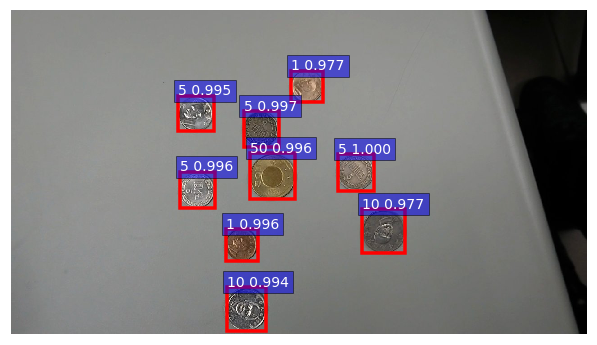

127.0.0.1 - - [05/Jan/2019 20:38:56] "POST /predict HTTP/1.1" 200 -


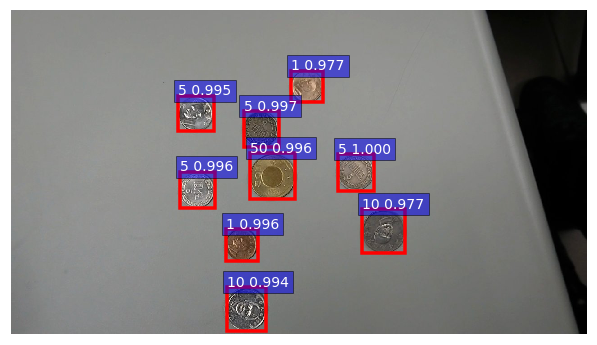

127.0.0.1 - - [05/Jan/2019 20:39:45] "POST /predict HTTP/1.1" 200 -


In [ ]:
if __name__ == '__main__':
    app.run(debug=False)

In [ ]:
cv2.destroyAllWindows()